## 60 Minute Blitz, **<(￣︶￣)↗[GO!]**

### Training A Classifier

#### What about data？

一般来说，处理图片、文本、音频或视频数据时，首先利用标准Python包来加载数据到numpy array，然后便可以将array转换为`torch.*Tensor`

- images
    - Pillow, OpenCV
- audio
    - scipy, librosa
- text
    - raw Python/Cython based loading, NLTK, SpaCy

Pytorch针对视觉任务建立了`torchvision`包，该包包含常见数据集（*如ImageNet, CIFAR10, MNIST*）的数据加载器以及图像数据转换器（*即`torchvison.datasets`和`torch.utils.data.DataLoader`*）

以下内容采用CIFAR-10，size为3x32x32，共十个类如图

![jupyter](./pics/cifar10.png)

### Traing a image classifier

##### 步骤
1. 用`torchvison`加载和归一化CIFAR10 训练集和测试集
2. 定义卷积神经网络
3. 定义损失函数
4. 用训练集训练网络
5. 用测试集测试网络

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

1. 加载和归一化(*正规化？normalizing*)CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision数据集的输出是值为[0,1]的PILImage。这里将他们归一化为[-1,1]的tensors

In [3]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=2)
classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


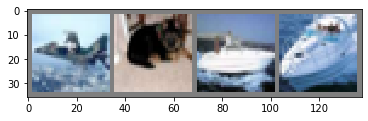

plane   dog  ship  ship


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img=img/2+0.5 #unnormalize
    npImg=img.numpy()
    plt.imshow(np.transpose(npImg,(1,2,0)))
    plt.show()

# get some random traning images
dataiter=iter(trainloader)
images,labels=dataiter.next()

#show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4))) 

2. Define a Convolutional Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(3,100,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(100,16,5)
        self.fc1=nn.Linear(16*5*5,120) #6*6来自于图像维度
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
net=Net()

3. Define a Loss function and optimizer

此处使用交叉熵函数和SGD with Momentum

In [6]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

4. Train the network

遍历数据迭代器，将输入送入网络并进行优化

In [7]:
%%time
for epoch in range(2):
    running_loss=0
    for i,data in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs,labels=data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step() # Does the update
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
            running_loss=0.0
print("Finished Training")

[1,  2000] loss: 2.049
[1,  4000] loss: 1.685
[1,  6000] loss: 1.524
[1,  8000] loss: 1.444
[1, 10000] loss: 1.414
[1, 12000] loss: 1.353
[2,  2000] loss: 1.255
[2,  4000] loss: 1.232
[2,  6000] loss: 1.189
[2,  8000] loss: 1.150
[2, 10000] loss: 1.170
[2, 12000] loss: 1.118
Finished Training
Wall time: 6min 1s


5. Test the network on the test data

先看一下测试集的图片

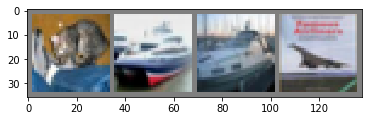

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter=iter(testloader)
images,labels=dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' %classes[labels[j]] for j in range(4))) 

神经网络的识别结果如下：

In [9]:
outputs=net(images)

输出是10类的能量。 一个类别的能量越高，网络就认为该图像属于特定类别。 因此，我们获取最高能量的索引：

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship plane plane


看起来效果一般，接下来看一下网络在整个测试集上的性能

In [11]:
correct = 0
total= 0
with torch.no_grad():
    for data in testloader:
        images, labels=data
        outputs=net(images)
        _, predicted = torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

print("Accuracy of the network on the 10000 test images: %d %%" % (100*correct/total))

Accuracy of the network on the 10000 test images: 61 %


随机选择分类正确的概率是10%，因而网络应该是学到了一些东西。

下面看一下每个类别的分类准确度怎么样：

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs=net(images)
        _, predicted = torch.max(outputs,1)
        c=(predicted==labels).squeeze()
        for i in range(4):
            label=labels[i]
            class_correct[label] += c[i].item()
            class_total[label]+=1

for i in range(10):
    print('Accuracy of %5s: %2s %%' % (classes[i], 100*class_correct[i]/class_total[i]))
            

Accuracy of plane: 80.6 %
Accuracy of   car: 71.1 %
Accuracy of  bird: 53.4 %
Accuracy of   cat: 44.2 %
Accuracy of  deer: 57.2 %
Accuracy of   dog: 47.7 %
Accuracy of  frog: 57.0 %
Accuracy of horse: 65.3 %
Accuracy of  ship: 58.4 %
Accuracy of truck: 76.4 %


#### Training on GPU

正如可以传递一个Tensor到GPU，也可以传递神经网络到GPU

如果可以使用CUDA，首先将我们的设备定义为第一个可见的cuda设备：

In [14]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


现在的设备是CUDA设备。

下面的这些方法会递归遍历所有模块并将参数和缓冲转换为CUDA tensors:

In [15]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

**注意**，还必须将每一步的输入和目标也发送给GPU

In [22]:
inputs,labels=data[0].to(device),data[1].to(device)